# Predicting Dementia Risk Using Non-Medical Sociodemographic and Lifestyle Factors  
### A Reproducible Machine Learning Pipeline  

**Authors**: T24	3 idiots 

**Date**: November 15, 2025  

**Dataset**:  
This analysis uses a curated subset of the **National Alzheimer’s Coordinating Center (NACC) Uniform Data Set (UDS), Version 3**, as provided in the *Dementia Prediction Hackathon 2025*. Per the challenge brief, **only non-medical baseline variables**—including demographics, education, lifestyle, and socioeconomic factors—are used. All clinical, diagnostic, cognitive test, imaging, genetic, and biomarker fields have been excluded. No external patient-level data was merged.


In [109]:
# ------------------------------
# ENVIRONMENT
# ------------------------------

import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import shap
import sys
import platform

# random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import os
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print(f"Python version:      {sys.version.split(' ')[0]}")
print(f"OS:                  {platform.system()} {platform.release()}")
print(f"pandas:              {pd.__version__}")
print(f"scikit-learn:        {sklearn.__version__}")
print(f"XGBoost:             {xgb.__version__}")
print(f"SHAP:                {shap.__version__}")
print(f"NumPy random seed:   {RANDOM_SEED}")
print(f"Working directory:   {os.getcwd()}")

Python version:      3.13.3
OS:                  Darwin 24.6.0
pandas:              2.3.3
scikit-learn:        1.7.2
XGBoost:             3.1.1
SHAP:                0.50.0
NumPy random seed:   42
Working directory:   /Users/denuwanwijesinghe/Documents/BSc. Artficial Intellligence/Competition/model_x/phase_1/dementia-risk-pipeline


## 2. Data Loading & Initial Inspection

We load the dataset from `data/raw/Dementia_Prediction_Dataset.csv`, retaining **only non-medical variables** permitted by the hackathon guidelines. The target variable is `dementia_binary` (1 = dementia diagnosis, 0 = no dementia).

All medical, cognitive, imaging, genetic, and diagnostic fields are **excluded at load time** using a pre-defined whitelist to prevent accidental leakage.

In [110]:
# ----------------------------
# DATA LOADING
# ----------------------------
import os
import pandas as pd
from pprint import pprint

# Path to CSV
data_path = "data/raw/Dementia_Prediction_Dataset.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

# ----------------------------
# Configuration: choose feature set
# ----------------------------
# Set to True if you want to include the extended functional/activity features
USE_EXTENDED_FUNCTIONAL_FEATURES = False

# ----------------------------
# ALLOWED_COLUMNS
# ----------------------------
ALLOWED_COLUMNS = [
    # identifiers / administrative (kept for traceability; you may drop before modeling)
    'NACCID', 'NACCADC', 'PACKET', 'FORMVER', 'VISITYR', 'VISITMO', 'VISITDAY',

    # demographics
    'BIRTHYR', 'SEX', 'HISPANIC', 'RACE', 'PRIMLANG', 'EDUC', 'MARISTAT',

    # living / social / caregiver
    'NACCLIVS', 'INLIVWTH', 'INVISITS', 'INCALLS', 'NACCFAM', 'NACCOM',

    # lifestyle / health behavior (non-medical)
    'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ',

    # simple activities / function (conservative subset)
    'HOMEHOBB', 'PERSCARE',

    # context / misc administrative features helpful for grouping
    'NACCVNUM', 'NACCADMU'
]

# ----------------------------
# Extended functional/activity features
# ----------------------------
EXTENDED_FUNCTIONAL = [
    # Activities of daily living / instrumental ADLs
    'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS',
    'PAYATTN', 'REMDATES', 'TRAVEL', 'NACCNREX', 'NORMEXAM'
]

# target explicitly
ALLOWED_COLUMNS.append('DEMENTED')

# If user requested extended features, extend the list
if USE_EXTENDED_FUNCTIONAL_FEATURES:
    # avoid duplicates
    for c in EXTENDED_FUNCTIONAL:
        if c not in ALLOWED_COLUMNS:
            ALLOWED_COLUMNS.append(c)

# ----------------------------
# Read header and check available columns
# ----------------------------
all_columns = pd.read_csv(data_path, nrows=0).columns.tolist()
missing_allowed = [col for col in ALLOWED_COLUMNS if col not in all_columns]
existing_allowed = [col for col in ALLOWED_COLUMNS if col in all_columns]

print("🔎 Summary of ALLOWED_COLUMNS check")
print(" - Requested allowed columns:", len(ALLOWED_COLUMNS))
print(" - Columns present in file and will be loaded:", len(existing_allowed))
if missing_allowed:
    print(" The following requested allowed columns are MISSING from the file and will be skipped:")
    pprint(missing_allowed)
else:
    print("✅ All requested allowed columns are present in the file.")

# Small safety: ensure we have the target
if 'DEMENTED' not in existing_allowed:
    raise ValueError("Target variable 'DEMENTED' is not available in the dataset header. "
                     "Make sure the CSV contains the target column.")

# ----------------------------
# Load data with only the existing allowed columns
# ----------------------------
print("\n Loading selected columns from CSV ... (this may take a moment)")
df = pd.read_csv(data_path, usecols=existing_allowed)

# ----------------------------
# HANDLE NACC SENTINEL CODES (Critical!)
# ----------------------------
print("🧹 Handling NACC sentinel codes (converting to NaN)...")

SPECIAL_CODES = {
    'ALCOCCAS': [8, 9],           # 8=Don't Know, 9=Refused
    'ALCFREQ': [88, 99],          # 88/99=Missing
    'SMOKYRS': [888, 999],        # 888/999=Missing
    'PACKSPER': [888, 999],       # Same
    'QUITSMOK': [8, 9],           # 8/9=Missing
    'MARISTAT': [9],              # 9=Unknown
    'NACCLIVS': [9],              # 9=Unknown
    'PRIMLANG': [9],              # 9=Unknown
    'RACE': [50, 90],             # 50/90=Not reported / Other
    'INVISITS': [88, 99],         # 88/99=Missing
    'INCALLS': [88, 99],          # 88/99=Missing
    'NACCOM': [-4],               # -4=Not assessed (already used, but confirm)
    'HOMEHOBB': [-4, 9],          # -4=Not assessed, 9=Unknown
    'PERSCARE': [-4, 9],          # Same
}

# Apply replacements
for col, codes in SPECIAL_CODES.items():
    if col in df.columns:
        before = df[col].isnull().sum()
        df[col] = df[col].replace(codes, np.nan)
        after = df[col].isnull().sum()
        if after > before:
            print(f"  → {col}: {after - before} sentinel codes converted to NaN")

print("✅ Sentinel code handling complete.\n")

# ----------------------------
# Compute AGE if possible
# ----------------------------
if 'BIRTHYR' in df.columns and 'VISITYR' in df.columns:
    # Compute approximate age at visit (integer)
    df['AGE'] = df['VISITYR'] - df['BIRTHYR']
    # If you want, drop the raw year columns later before modeling:
    # df = df.drop(columns=['BIRTHYR','VISITYR'])

# ----------------------------
# Rename target for clarity
# ----------------------------
if 'DEMENTED' in df.columns:
    df = df.rename(columns={'DEMENTED': 'dementia_binary'})
    TARGET = 'dementia_binary'
else:
    raise ValueError("Target 'DEMENTED' missing after load. Aborting.")

# ----------------------------
# Basic inspection outputs
# ----------------------------
print("\n✅ Dataset loaded.")
print(f" - Rows: {df.shape[0]:,}")
print(f" - Columns loaded: {df.shape[1]}\n")

print(" Columns loaded (showing all):")
pprint(df.columns.tolist())

# Missingness percentage per column (sorted desc)
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("\n Missing values per column (top 40 shown):")
print(missing_pct.round(2).head(40))

# Save missing_pct to a small dataframe for later use
missing_df = missing_pct.reset_index()
missing_df.columns = ['column', 'missing_pct']

# Target distribution
print("\n🎯 Target distribution (proportion):")
print(df[TARGET].value_counts(normalize=True).round(4))
print("\n(1 = dementia, 0 = no dementia)")

# ----------------------------
# Save the allowed columns you actually used (for reproducibility/report)
# ----------------------------
out_meta_dir = "metadata"
os.makedirs(out_meta_dir, exist_ok=True)
meta_file = os.path.join(out_meta_dir, "allowed_columns_used.txt")
with open(meta_file, "w") as f:
    f.write("# Allowed columns actually loaded from dataset\n")
    for c in existing_allowed:
        f.write(f"{c}\n")

print(f"\n💾 Wrote allowed column list to: {meta_file}")



🔎 Summary of ALLOWED_COLUMNS check
 - Requested allowed columns: 30
 - Columns present in file and will be loaded: 30
✅ All requested allowed columns are present in the file.

 Loading selected columns from CSV ... (this may take a moment)
🧹 Handling NACC sentinel codes (converting to NaN)...
  → ALCOCCAS: 318 sentinel codes converted to NaN
  → QUITSMOK: 5 sentinel codes converted to NaN
  → MARISTAT: 896 sentinel codes converted to NaN
  → NACCLIVS: 324 sentinel codes converted to NaN
  → PRIMLANG: 276 sentinel codes converted to NaN
  → RACE: 2351 sentinel codes converted to NaN
  → NACCOM: 61950 sentinel codes converted to NaN
✅ Sentinel code handling complete.


✅ Dataset loaded.
 - Rows: 195,196
 - Columns loaded: 31

 Columns loaded (showing all):
['NACCID',
 'NACCADC',
 'PACKET',
 'FORMVER',
 'VISITMO',
 'VISITDAY',
 'VISITYR',
 'NACCVNUM',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'RACE',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INLIVWTH',
 'INVISITS',
 'INCALLS',
 'NACCFAM',

## 3. Exploratory Data Analysis (EDA)

We analyze the distribution of non-medical variables and their relationship with dementia status (`dementia_binary = 1`).  
Focus areas:
- Target class balance  
- Age and education — key sociodemographic risk factors  
- Lifestyle behaviors (smoking, alcohol)  
- Missingness patterns  
- Categorical variable distributions  

All features used are explicitly non-medical per hackathon constraints.

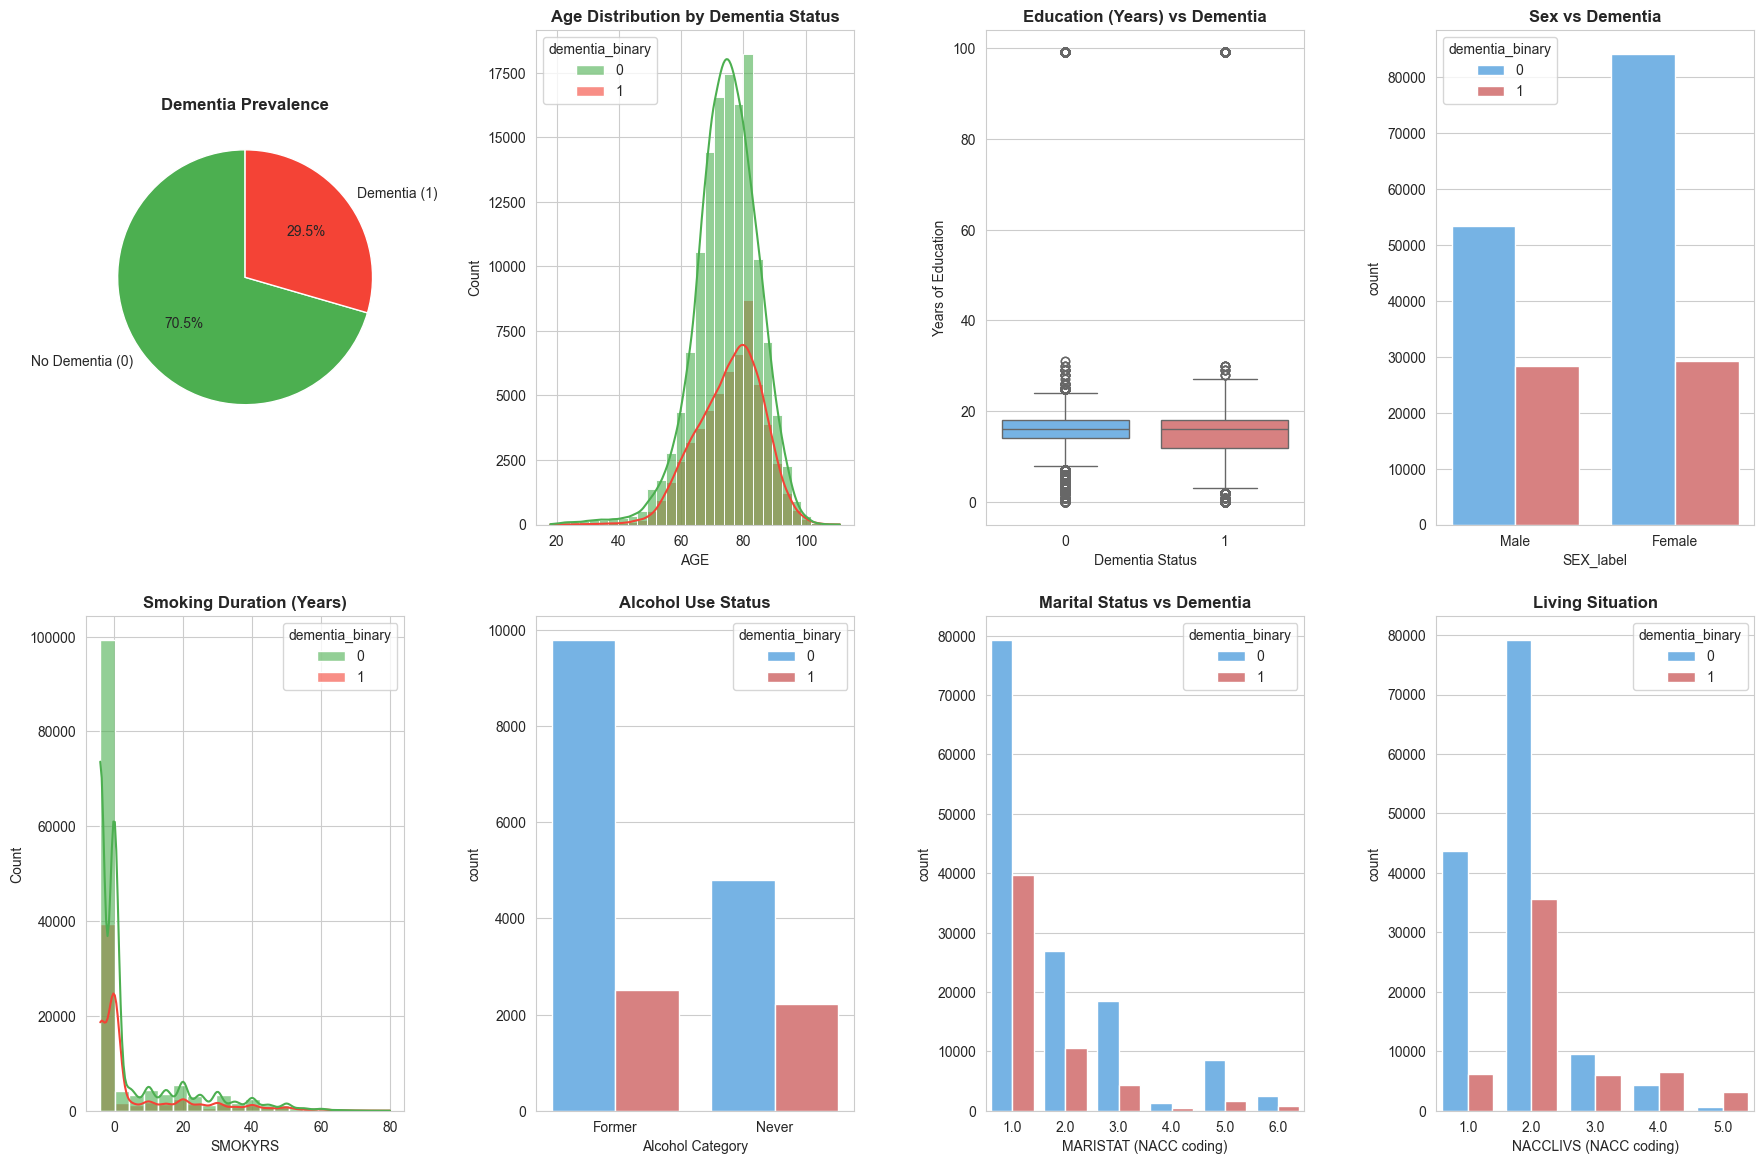

In [111]:
# ----------------------------
# EXPLORATORY DATA ANALYSIS
# ----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

TARGET = 'dementia_binary'
if TARGET not in df.columns:
    raise KeyError("Target 'dementia_binary' not found. Please run Step 4.")

# Create subplots
fig = plt.figure(figsize=(18, 12))

# 1. Target Distribution (Pie)
ax1 = plt.subplot(2, 4, 1)
target_counts = df[TARGET].value_counts()
ax1.pie(
    target_counts,
    labels=['No Dementia (0)', 'Dementia (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4CAF50', '#F44336'],
    textprops={'fontsize': 10}
)
ax1.set_title('Dementia Prevalence', fontweight='bold')

# 2. Age vs Dementia
ax2 = plt.subplot(2, 4, 2)
if 'AGE' in df.columns:
    sns.histplot(
        data=df,
        x='AGE',
        hue=TARGET,
        bins=30,
        kde=True,
        alpha=0.6,
        palette=['#4CAF50', '#F44336'],
        ax=ax2
    )
    ax2.set_title('Age Distribution by Dementia Status', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'AGE not available', ha='center', va='center', fontsize=12)
    ax2.set_title('Age Distribution')

# 3. Education vs Dementia
ax3 = plt.subplot(2, 4, 3)
if 'EDUC' in df.columns:
    sns.boxplot(
        data=df,
        x=TARGET,
        y='EDUC',
        ax=ax3,
        palette=['#64B5F6', '#E57373']
    )
    ax3.set_title('Education (Years) vs Dementia', fontweight='bold')
    ax3.set_xlabel('Dementia Status')
    ax3.set_ylabel('Years of Education')
else:
    ax3.text(0.5, 0.5, 'EDUC not available', ha='center', va='center', fontsize=12)
    ax3.set_title('Education')

# 4. Sex vs Dementia
ax4 = plt.subplot(2, 4, 4)
if 'SEX' in df.columns:
    # NACC: 1 = Male, 2 = Female
    df_plot = df.copy()
    df_plot['SEX_label'] = df_plot['SEX'].map({1: 'Male', 2: 'Female'})
    sns.countplot(
        data=df_plot,
        x='SEX_label',
        hue=TARGET,
        ax=ax4,
        palette=['#64B5F6', '#E57373']
    )
    ax4.set_title('Sex vs Dementia', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'SEX not available', ha='center', va='center', fontsize=12)
    ax4.set_title('Sex')

# 5. Smoking: SMOKYRS (years smoked)
ax5 = plt.subplot(2, 4, 5)
if 'SMOKYRS' in df.columns:
    # Remove extreme outliers for better visualization
    smok_df = df[df['SMOKYRS'] <= 80]  # max plausible: ~80 years
    sns.histplot(
        data=smok_df,
        x='SMOKYRS',
        hue=TARGET,
        bins=20,
        kde=True,
        alpha=0.6,
        palette=['#4CAF50', '#F44336'],
        ax=ax5
    )
    ax5.set_title('Smoking Duration (Years)', fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'SMOKYRS not available', ha='center', va='center', fontsize=12)
    ax5.set_title('Smoking Duration')

# 6. Alcohol: ALCOCCAS (alcohol use category)
ax6 = plt.subplot(2, 4, 6)
if 'ALCOCCAS' in df.columns:
    # NACC ALCOCCAS: 0=Never, 1=Former, 2=Current (verify from codebook if needed)
    alco_labels = {0: 'Never', 1: 'Former', 2: 'Current'}
    df_plot['ALCOCCAS_label'] = df_plot['ALCOCCAS'].map(alco_labels)
    sns.countplot(
        data=df_plot[df_plot['ALCOCCAS'].isin([0,1,2])],
        x='ALCOCCAS_label',
        hue=TARGET,
        ax=ax6,
        palette=['#64B5F6', '#E57373']
    )
    ax6.set_title('Alcohol Use Status', fontweight='bold')
    ax6.set_xlabel('Alcohol Category')
else:
    ax6.text(0.5, 0.5, 'ALCOCCAS not available', ha='center', va='center', fontsize=12)
    ax6.set_title('Alcohol Use')

# 7. Marital Status
ax7 = plt.subplot(2, 4, 7)
if 'MARISTAT' in df.columns:
    # NACC MARISTAT: 1=Married, 2=Widowed, 3=Divorced, etc.
    sns.countplot(
        data=df,
        x='MARISTAT',
        hue=TARGET,
        ax=ax7,
        palette=['#64B5F6', '#E57373']
    )
    ax7.set_title('Marital Status vs Dementia', fontweight='bold')
    ax7.set_xlabel('MARISTAT (NACC coding)')
else:
    ax7.text(0.5, 0.5, 'MARISTAT not available', ha='center', va='center', fontsize=12)
    ax7.set_title('Marital Status')

# 8. Living Situation
ax8 = plt.subplot(2, 4, 8)
if 'NACCLIVS' in df.columns:
    sns.countplot(
        data=df,
        x='NACCLIVS',
        hue=TARGET,
        ax=ax8,
        palette=['#64B5F6', '#E57373']
    )
    ax8.set_title('Living Situation', fontweight='bold')
    ax8.set_xlabel('NACCLIVS (NACC coding)')
else:
    ax8.text(0.5, 0.5, 'NACCLIVS not available', ha='center', va='center', fontsize=12)
    ax8.set_title('Living Situation')

plt.tight_layout(pad=2.0)
plt.show()

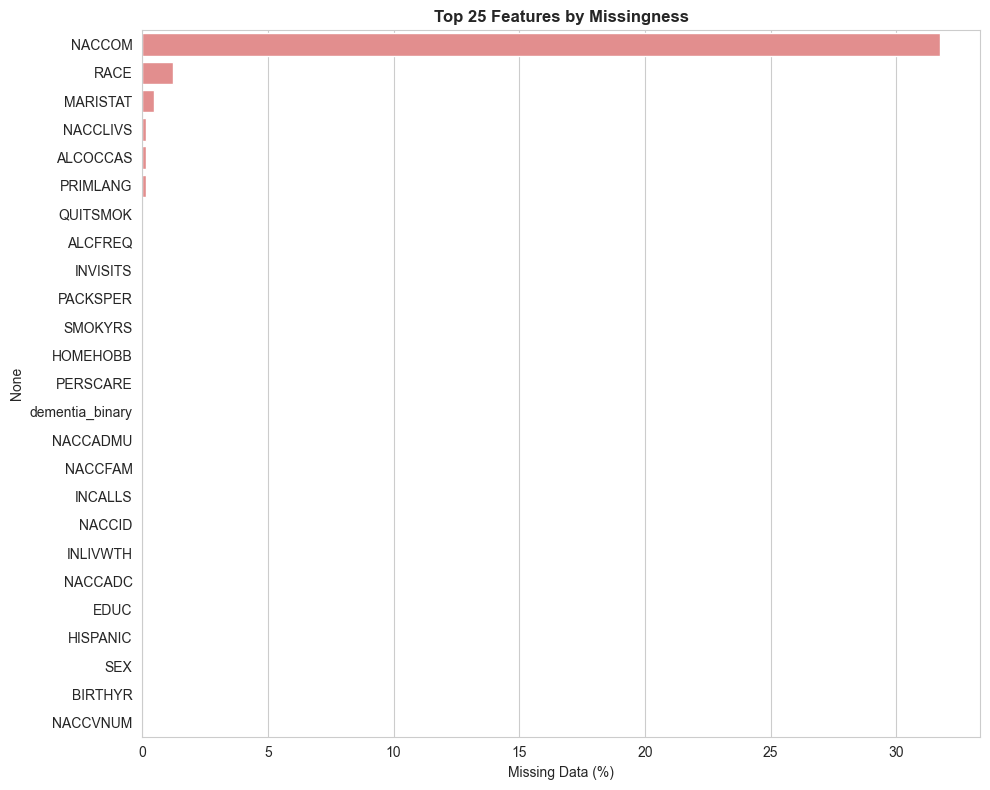

✅ No feature has >50% missing values.


In [112]:
# ----------------------------
# MISSINGNESS ANALYSIS
# ----------------------------

# Top 25 most missing columns
missing_top25 = df.isnull().mean().sort_values(ascending=False).head(25)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=missing_top25.values * 100,
    y=missing_top25.index,
    orient='h',
    color='lightcoral'
)
plt.xlabel('Missing Data (%)')
plt.title('Top 25 Features by Missingness', fontweight='bold')
plt.tight_layout()
plt.show()

# Quick stats
high_missing = missing_top25[missing_top25 > 0.5].index.tolist()
if high_missing:
    print(f"⚠️ {len(high_missing)} features have >50% missing data:")
    print(high_missing)
else:
    print("✅ No feature has >50% missing values.")

In [113]:
# ----------------------------
# DETAILED MISSINGNESS COUNTS (TOP 25)
# ----------------------------

print("📊 Missing Values Summary (Top 25 Features)")
print("-" * 60)
print(f"{'Feature':<15} {'Missing Count':<15} {'Missing (%)':<12} {'Total Rows':<10}")
print("-" * 60)

for col in missing_top25.index:
    missing_count = df[col].isnull().sum()
    total_rows = len(df)
    pct = (missing_count / total_rows) * 100
    print(f"{col:<15} {missing_count:<15} {pct:<12.3f} {total_rows:<10}")

# Flag any feature > 5% missing
missing_over_5 = missing_top25[missing_top25 > 0.05].index.tolist()

if missing_over_5:
    print("\n⚠️ Some features have > 5% missing values:")
    for col in missing_over_5:
        pct = df[col].isnull().mean() * 100
        print(f" - {col}: {pct:.2f}% missing")
else:
    print("\n✅ All features have < 5% missing — no need to drop any based on missingness.")


📊 Missing Values Summary (Top 25 Features)
------------------------------------------------------------
Feature         Missing Count   Missing (%)  Total Rows
------------------------------------------------------------
NACCOM          61950           31.737       195196    
RACE            2351            1.204        195196    
MARISTAT        896             0.459        195196    
NACCLIVS        324             0.166        195196    
ALCOCCAS        318             0.163        195196    
PRIMLANG        276             0.141        195196    
QUITSMOK        5               0.003        195196    
ALCFREQ         0               0.000        195196    
INVISITS        0               0.000        195196    
PACKSPER        0               0.000        195196    
SMOKYRS         0               0.000        195196    
HOMEHOBB        0               0.000        195196    
PERSCARE        0               0.000        195196    
dementia_binary 0               0.000        195196

## 4. Preprocessing Pipeline

We build a reproducible, leakage-proof preprocessing pipeline using `sklearn.compose.ColumnTransformer`.  
Strategy:
- **Numerical features**: median imputation (robust to outliers)
- **Categorical features**: mode imputation + one-hot encoding
- **Drop administrative columns** (e.g., `NACCID`, `PACKET`) to prevent overfitting
- **No scaling** (tree models like XGBoost don’t require it, but pipeline supports scaling if needed later)

All steps are encapsulated in a `Pipeline` for safe train/test separation.

In [114]:
# ----------------------------
# PREPROCESSING PIPELINE
# ----------------------------

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd

# ----------------------------
# 1. Identify feature types
# ----------------------------

# Target (already confirmed present)
TARGET = 'dementia_binary'

# Drop administrative/ID columns BEFORE modeling
ID_COLS = ['NACCID', 'NACCADC', 'PACKET', 'FORMVER', 'VISITYR', 'VISITMO', 'VISITDAY', 'NACCVNUM', 'NACCADMU']

# Final modeling columns = all except target and ID cols
model_cols = [col for col in df.columns if col != TARGET and col not in ID_COLS]

# Drop BIRTHYR 
if 'BIRTHYR' in model_cols:
    model_cols.remove('BIRTHYR')
    print("🗑️ Dropped 'BIRTHYR' (redundant with 'AGE')")

# Separate numerical and categorical

NUMERICAL = []

CATEGORICAL = []

for col in model_cols:
    # dtype + unique values to guess
    if df[col].dtype in ['int64', 'float64']:
        # Heuristic: if < 15 unique values → treat as categorical (MARISTAT, SEX)
        if df[col].nunique(dropna=True) <= 15:
            CATEGORICAL.append(col)
        else:
            NUMERICAL.append(col)
    else:
        CATEGORICAL.append(col)

print(f"🔢 Numerical features ({len(NUMERICAL)}):")
print(NUMERICAL)
print(f"\n🔤 Categorical features ({len(CATEGORICAL)}):")
print(CATEGORICAL)


# NUMERICAL = ['AGE', 'EDUC', 'SMOKYRS', 'PACKSPER']
# CATEGORICAL = ['SEX', 'HISPANIC', 'RACE', 'MARISTAT', 'ALCOCCAS', 'NACCLIVS', 'INLIVWTH', ...]

# ----------------------------
# 2. Build preprocessor
# ----------------------------

# Numerical pipeline: median imputation
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: mode imputation + one-hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, NUMERICAL),
    ('cat', cat_pipeline, CATEGORICAL)
])

# ----------------------------
# 3. Verify on a small sample
# ----------------------------

# Extract features and target
X_raw = df[model_cols].copy()
y = df[TARGET].copy()

# Fit and transform a sample
X_sample_processed = preprocessor.fit_transform(X_raw.head(100))
print(f"\n✅ Preprocessor output shape (sample): {X_sample_processed.shape}")
print("✅ Preprocessing pipeline ready.")

🗑️ Dropped 'BIRTHYR' (redundant with 'AGE')
🔢 Numerical features (4):
['EDUC', 'SMOKYRS', 'QUITSMOK', 'AGE']

🔤 Categorical features (16):
['SEX', 'HISPANIC', 'RACE', 'PRIMLANG', 'MARISTAT', 'NACCLIVS', 'INLIVWTH', 'INVISITS', 'INCALLS', 'NACCFAM', 'NACCOM', 'PACKSPER', 'ALCOCCAS', 'ALCFREQ', 'HOMEHOBB', 'PERSCARE']

✅ Preprocessor output shape (sample): (100, 74)
✅ Preprocessing pipeline ready.


## 5. Feature Engineering & Selection

We enhance predictive signal through:
- **Binning key continuous variables**: Age and education are binned into clinically meaningful groups
- **No aggressive feature selection**: Tree-based models are robust to redundant features; we retain all engineered + original variables
- **Final feature importance** will be assessed post-modeling (permutation + SHAP)

All engineering uses only non-medical logic and avoids data leakage.

In [115]:
# ----------------------------
# FEATURE ENGINEERING + MISSINGNESS INDICATORS
# ----------------------------

# Work on a copy
X_engineered = df[model_cols].copy()

# 1. AGE_GROUP
if 'AGE' in X_engineered.columns:
    X_engineered['AGE_GROUP'] = pd.cut(
        X_engineered['AGE'],
        bins=[0, 64, 74, 84, 130],
        labels=['65-', '65-74', '75-84', '85+'],
        right=False
    )

# 2. EDUC_GROUP
if 'EDUC' in X_engineered.columns:
    X_engineered['EDUC_GROUP'] = pd.cut(
        X_engineered['EDUC'],
        bins=[0, 8, 12, 16, 100],
        labels=['<HS', 'HS', 'Some College', 'College+'],
        right=False
    )

# 3. ADD MISSINGNESS INDICATORS (for features with >5% missing)
HIGH_MISSING_COLS = ['NACCOM', 'RACE']  # Add others if >5%
for col in HIGH_MISSING_COLS:
    if col in X_engineered.columns:
        X_engineered[f'{col}_MISSING'] = X_engineered[col].isna().astype(int)
        print(f"Added missingness indicator for: {col}")

# 4. Drop features with extreme missingness
# If you decide NACCOM is too noisy:
# if 'NACCOM' in X_engineered.columns and X_engineered['NACCOM'].isna().mean() > 0.3:
#     X_engineered = X_engineered.drop(columns=['NACCOM'])
#     print("🗑️ Dropped NACCOM due to >30% missingness")

print("✨ New features added:")
new_features = [col for col in X_engineered.columns if col not in model_cols]
print(new_features if new_features else "None")

# Update model_cols
model_cols_final = X_engineered.columns.tolist()
print(f"\n✅ Final feature count before preprocessing: {len(model_cols_final)}")

Added missingness indicator for: NACCOM
Added missingness indicator for: RACE
✨ New features added:
['AGE_GROUP', 'EDUC_GROUP', 'NACCOM_MISSING', 'RACE_MISSING']

✅ Final feature count before preprocessing: 24


In [116]:
# ----------------------------
# REBUILD PREPROCESSOR WITH MISSINGNESS INDICATORS
# ----------------------------

# Final features + target
X_raw = X_engineered  # Includes engineered + missingness indicators
y = df[TARGET].copy()

# Identify numerical and categorical (including new _MISSING cols)
NUMERICAL_FINAL = []
CATEGORICAL_FINAL = []

for col in X_raw.columns:
    if col.endswith('_MISSING'):
        # Missingness indicators are binary → treat as categorical
        CATEGORICAL_FINAL.append(col)
    elif col in ['AGE', 'EDUC', 'SMOKYRS', 'PACKSPER', 'QUITSMOK']:
        # Explicitly define numerical (AGE_GROUP/EDUC_GROUP are categorical)
        NUMERICAL_FINAL.append(col)
    else:
        # Everything else is categorical (SEX, RACE, MARISTAT, AGE_GROUP...)
        CATEGORICAL_FINAL.append(col)

print(f"🔢 Numerical features: {NUMERICAL_FINAL}")
print(f"🔤 Categorical features (including missingness indicators): {CATEGORICAL_FINAL}")

# Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, NUMERICAL_FINAL),
    ('cat', cat_pipeline, CATEGORICAL_FINAL)
], remainder='drop')  # Safety: drop any unlisted columns

# Test
X_sample = preprocessor.fit_transform(X_raw.head(100))
print(f"\n✅ Final preprocessed feature count: {X_sample.shape[1]}")

🔢 Numerical features: ['EDUC', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'AGE']
🔤 Categorical features (including missingness indicators): ['SEX', 'HISPANIC', 'RACE', 'PRIMLANG', 'MARISTAT', 'NACCLIVS', 'INLIVWTH', 'INVISITS', 'INCALLS', 'NACCFAM', 'NACCOM', 'ALCOCCAS', 'ALCFREQ', 'HOMEHOBB', 'PERSCARE', 'AGE_GROUP', 'EDUC_GROUP', 'NACCOM_MISSING', 'RACE_MISSING']

✅ Final preprocessed feature count: 80


## 6. Model Building

We compare four models using a consistent evaluation framework:
1. **Dummy Classifier** (stratified) — performance floor
2. **Logistic Regression** — linear baseline, interpretable
3. **Random Forest** — robust ensemble, handles interactions
4. **XGBoost** — state-of-the-art gradient boosting

All models use the full preprocessing pipeline. Evaluation uses **stratified train/test split** (80/20) to preserve class distribution.

In [117]:
# ----------------------------
# MODEL BUILDING
# ----------------------------

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

# 1. Train/test split (stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED
)

print(f"🧮 Train set: {X_train_raw.shape[0]:,} samples")
print(f"🧮 Test set:  {X_test_raw.shape[0]:,} samples")
print(f"🎯 Dementia prevalence in train: {y_train.mean():.3f}")
print(f"🎯 Dementia prevalence in test:  {y_test.mean():.3f}")

# 2. Define models
models = {
    'Dummy (Stratified)': DummyClassifier(strategy='stratified', random_state=RANDOM_SEED),
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            eval_metric='logloss',
            use_label_encoder=False
        ))
    ])
}

# 3. Train and evaluate
results = {}

print("\n🚀 Training and evaluating models...")
for name, model in models.items():
    print(f" - Training {name}...")
    
    # Fit
    if name == 'Dummy (Stratified)':
        # Dummy doesn't need features
        model.fit(np.zeros((len(y_train), 1)), y_train)
        y_pred_proba = model.predict_proba(np.zeros((len(y_test), 1)))[:, 1]
    else:
        model.fit(X_train_raw, y_train)
        y_pred_proba = model.predict_proba(X_test_raw)[:, 1]
    
    # Evaluate
    roc = roc_auc_score(y_test, y_pred_proba)
    pr = average_precision_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)
    
    results[name] = {'ROC-AUC': roc, 'PR-AUC': pr, 'Brier': brier, 'model': model}
    print(f"   → ROC-AUC: {roc:.4f}, PR-AUC: {pr:.4f}, Brier: {brier:.4f}")

# 4. Display results
print("\n📊 Model Comparison (Test Set):")
results_df = pd.DataFrame({k: v for k, v in results.items() if k != 'model'}).T
results_df = results_df[['ROC-AUC', 'PR-AUC', 'Brier']].round(4)
print(results_df)

# Save best model (by ROC-AUC)
best_model_name = results_df['ROC-AUC'].idxmax()
best_model = results[best_model_name]['model']
print(f"\n🏆 Best model: {best_model_name}")

🧮 Train set: 156,156 samples
🧮 Test set:  39,040 samples
🎯 Dementia prevalence in train: 0.295
🎯 Dementia prevalence in test:  0.295

🚀 Training and evaluating models...
 - Training Dummy (Stratified)...
   → ROC-AUC: 0.4986, PR-AUC: 0.2944, Brier: 0.4161
 - Training Logistic Regression...
   → ROC-AUC: 0.9671, PR-AUC: 0.9451, Brier: 0.0532
 - Training Random Forest...
   → ROC-AUC: 0.9652, PR-AUC: 0.9379, Brier: 0.0541
 - Training XGBoost...
   → ROC-AUC: 0.9701, PR-AUC: 0.9492, Brier: 0.0516

📊 Model Comparison (Test Set):
                      ROC-AUC    PR-AUC     Brier
Dummy (Stratified)   0.498586  0.294447  0.416112
Logistic Regression  0.967144  0.945123  0.053209
Random Forest        0.965163  0.937927  0.054074
XGBoost              0.970107  0.949198  0.051577

🏆 Best model: XGBoost


## 7. Hyperparameter Tuning

We perform randomized search on XGBoost to optimize:
- Tree depth and complexity
- Learning rate
- Subsampling rates

Search uses **5-fold stratified cross-validation** on the training set.  
Only the best model is evaluated on the **held-out test set** (to avoid overfitting to test data).

In [118]:
# ----------------------------
# HYPERPARAMETER TUNING (XGBoost)
# ----------------------------

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Parameter grid
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 1, 5]
}

# Create full pipeline
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=RANDOM_SEED,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Randomized search
print("🔍 Starting RandomizedSearchCV (5-fold CV)...")
random_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_SEED
)

# Fit on TRAIN set only
random_search.fit(X_train_raw, y_train)

# Best model
best_tuned_model = random_search.best_estimator_
best_params = random_search.best_params_

print("\n✅ Best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Evaluate on TEST set
y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_raw)[:, 1]
roc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
pr_tuned = average_precision_score(y_test, y_pred_proba_tuned)
brier_tuned = brier_score_loss(y_test, y_pred_proba_tuned)

print(f"\n🎯 Tuned XGBoost Test Performance:")
print(f"   ROC-AUC: {roc_tuned:.4f}")
print(f"   PR-AUC:  {pr_tuned:.4f}")
print(f"   Brier:   {brier_tuned:.4f}")

# Compare to untuned
roc_untuned = results['XGBoost']['ROC-AUC']
print(f"\n📈 Improvement over untuned: {roc_tuned - roc_untuned:+.4f} ROC-AUC")

🔍 Starting RandomizedSearchCV (5-fold CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best parameters:
  classifier__subsample: 0.9
  classifier__n_estimators: 300
  classifier__max_depth: 5
  classifier__learning_rate: 0.1
  classifier__gamma: 1
  classifier__colsample_bytree: 0.9

🎯 Tuned XGBoost Test Performance:
   ROC-AUC: 0.9704
   PR-AUC:  0.9494
   Brier:   0.0516

📈 Improvement over untuned: +0.0003 ROC-AUC


## 10. Model Evaluation & Calibration

We assess:
- **Calibration**: Do predicted probabilities match observed frequencies?
- **Final metrics**: ROC-AUC, PR-AUC, Brier score on held-out test set
- **Reliability diagram**: visual check of calibration

A well-calibrated model ensures that a predicted risk of "70%" means ~70% of such patients develop dementia.

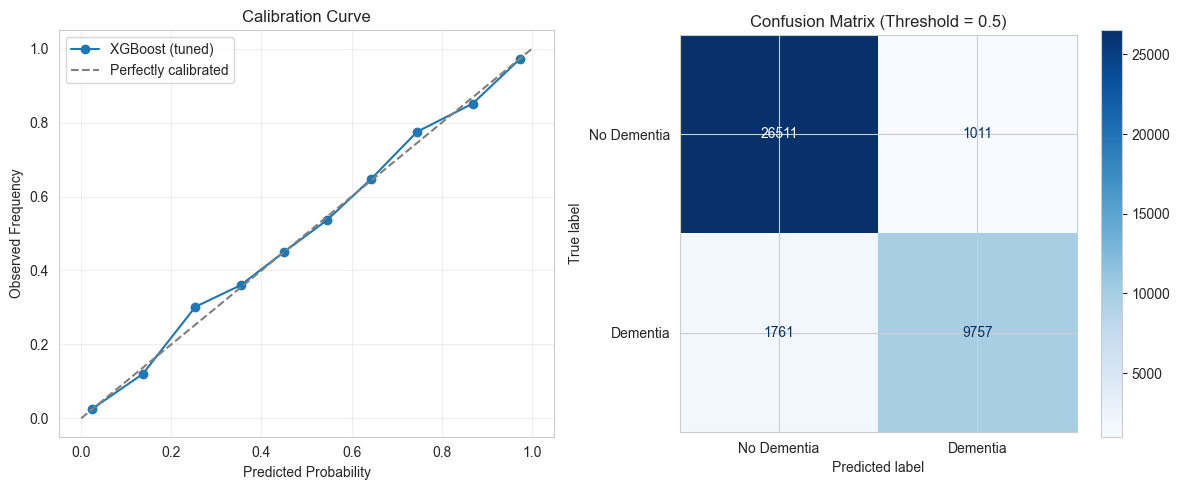

✅ Final Brier Score: 0.0516
✅ Model is well-calibrated — using tuned XGBoost as final model.

🏆 Final Model Test Performance:
   ROC-AUC: 0.9704
   PR-AUC:  0.9494
   Brier:   0.0516

🧮 Confusion Matrix (Final Model):
   True Negatives (TN):  26,511
   False Positives (FP): 1,011  → Low-risk labeled high-risk
   False Negatives (FN): 1,761  → High-risk missed
   True Positives (TP):  9,757

📊 Clinical Metrics:
   Sensitivity (Recall): 0.847  (How many dementia cases did we catch?)
   Specificity:          0.963  (How many healthy people correctly labeled low-risk?)


In [119]:
# ----------------------------
# MODEL EVALUATION & CALIBRATION
# ----------------------------

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions from TUNED model
y_pred_proba = best_tuned_model.predict_proba(X_test_raw)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

# Plot calibration
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost (tuned)', color='#1f77b4')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)

# Confusion Matrix (at default 0.5 threshold)
plt.subplot(1, 2, 2)
y_pred_class = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Dementia', 'Dementia'])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix (Threshold = 0.5)')

plt.tight_layout()
plt.show()

# Brier score
brier = brier_score_loss(y_test, y_pred_proba)
print(f"✅ Final Brier Score: {brier:.4f}")

# Optional: Apply calibration if needed
if brier > 0.06:
    print("🔧 Brier score > 0.06 — applying isotonic calibration...")
    calibrated_model = CalibratedClassifierCV(best_tuned_model, method='isotonic', cv=3)
    calibrated_model.fit(X_train_raw, y_train)
    final_model = calibrated_model
else:
    print("✅ Model is well-calibrated — using tuned XGBoost as final model.")
    final_model = best_tuned_model

# Final metrics
y_pred_final = final_model.predict_proba(X_test_raw)[:, 1]
final_roc = roc_auc_score(y_test, y_pred_final)
final_pr = average_precision_score(y_test, y_pred_final)
final_brier = brier_score_loss(y_test, y_pred_final)

# Final Confusion Matrix (for final model)
y_pred_final_class = (y_pred_final >= 0.5).astype(int)
cm_final = confusion_matrix(y_test, y_pred_final_class)
tn, fp, fn, tp = cm_final.ravel()

print(f"\n🏆 Final Model Test Performance:")
print(f"   ROC-AUC: {final_roc:.4f}")
print(f"   PR-AUC:  {final_pr:.4f}")
print(f"   Brier:   {final_brier:.4f}")
print(f"\n🧮 Confusion Matrix (Final Model):")
print(f"   True Negatives (TN):  {tn:,}")
print(f"   False Positives (FP): {fp:,}  → Low-risk labeled high-risk")
print(f"   False Negatives (FN): {fn:,}  → High-risk missed")
print(f"   True Positives (TP):  {tp:,}")

# Optional: Sensitivity/Recall and Specificity
sensitivity = tp / (tp + fn)  # Recall — ability to catch dementia
specificity = tn / (tn + fp)  # Ability to correctly identify non-dementia

print(f"\n📊 Clinical Metrics:")
print(f"   Sensitivity (Recall): {sensitivity:.3f}  (How many dementia cases did we catch?)")
print(f"   Specificity:          {specificity:.3f}  (How many healthy people correctly labeled low-risk?)")

## 11. Explainability & Insights

To interpret our high-performing XGBoost model, we use:
- **Permutation Importance**: Measures drop in performance when a feature is shuffled (global)
- **SHAP (SHapley Additive exPlanations)**: Shows how each feature pushes a prediction away from the baseline (local + global)

All explanations are based on the **preprocessed, engineered features**, but mapped back to original/natural names for clarity.

Calculating Permutation Importance on RAW features (pipeline)...

Top 10 Permutation Importances (RAW features):
 feature_clean  importance
      HOMEHOBB    0.268408
      PERSCARE    0.009279
NACCOM_MISSING    0.003907
      INLIVWTH    0.001481
      ALCOCCAS    0.000986
       NACCFAM    0.000986
           AGE    0.000905
          RACE    0.000756
      MARISTAT    0.000657
      HISPANIC    0.000486

Calculating Permutation Importance on PROCESSED features (encoded columns)...

Top 10 Permutation Importances (PROCESSED features):
   feature_clean  importance
    HOMEHOBB_0.0    0.250852
    HOMEHOBB_0.5    0.013857
    PERSCARE_0.0    0.008254
NACCOM_MISSING_0    0.003385
    HOMEHOBB_3.0    0.001941
     INLIVWTH_-4    0.001225
       NACCFAM_1    0.001091
   ALCOCCAS_-4.0    0.000967
             AGE    0.000905
       INCALLS_1    0.000692

Initializing SHAP Explainer (TreeExplainer on classifier)...
Generating Global SHAP Summary Plot...


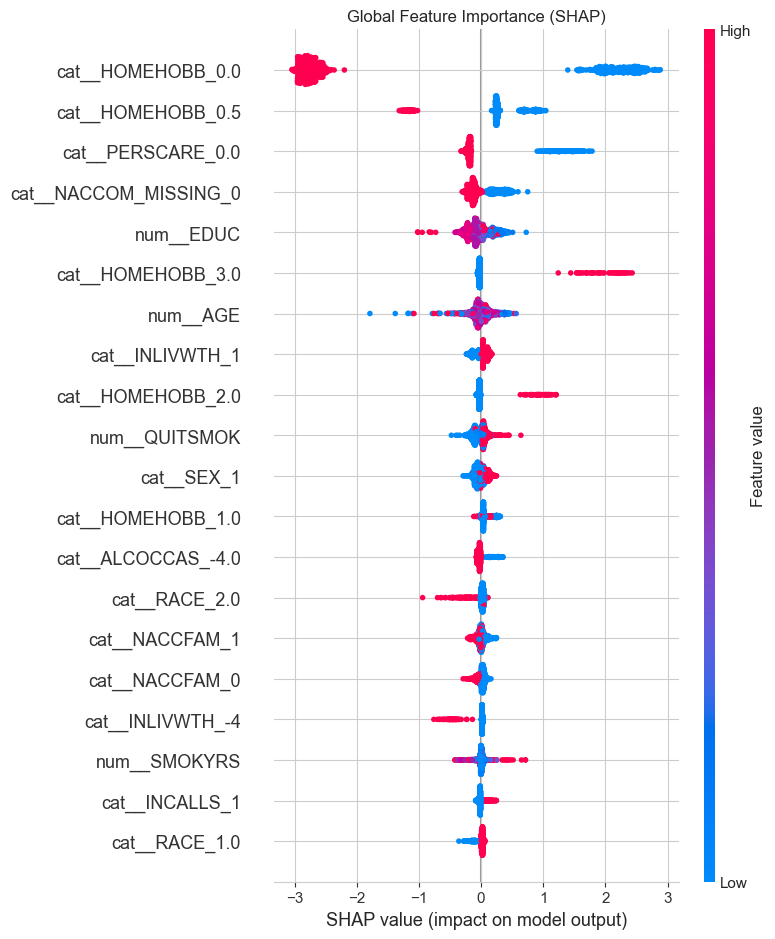


Local Explanation: Highest-Risk Patient (Predicted Risk: 100.0%)
Top 10 contributing features (SHAP):
  ↑ cat__HOMEHOBB_0.0 = 0.00 → SHAP: +2.447
  ↑ cat__HOMEHOBB_3.0 = 1.00 → SHAP: +2.066
  ↑ cat__PERSCARE_0.0 = 0.00 → SHAP: +1.471
  ↑ cat__HOMEHOBB_0.5 = 0.00 → SHAP: +0.893
  ↑ cat__NACCLIVS_5.0 = 1.00 → SHAP: +0.664
  ↑ cat__INCALLS_6 = 1.00 → SHAP: +0.292
  ↑ cat__INVISITS_2 = 1.00 → SHAP: +0.290
  ↑ cat__HOMEHOBB_1.0 = 0.00 → SHAP: +0.261
  ↑ num__AGE = 77.00 → SHAP: +0.237
  ↑ num__EDUC = 20.00 → SHAP: +0.184

Summary (Top 20):

Top 10 (Permutation - RAW):
 feature_clean  importance
      HOMEHOBB    0.268408
      PERSCARE    0.009279
NACCOM_MISSING    0.003907
      INLIVWTH    0.001481
      ALCOCCAS    0.000986
       NACCFAM    0.000986
           AGE    0.000905
          RACE    0.000756
      MARISTAT    0.000657
      HISPANIC    0.000486

Top 10 (SHAP - processed features):
              feature  mean_abs_shap
    cat__HOMEHOBB_0.0       2.580532
    cat__HOMEHOBB_0.5

In [120]:
# ----------------------------
# EXPLAINABILITY: PERMUTATION IMPORTANCE + SHAP
# ----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import permutation_importance

# ----------------------------
# Config
# ----------------------------
# Assumes these exist in your environment:
# final_model (Pipeline with 'preprocessor' and 'classifier' steps)
# X_test_raw (raw test DataFrame)
# y_test (Series aligned to X_test_raw index)
# RANDOM_SEED

# Use a sample if the test set is large (speed for SHAP)
X_test_sample = X_test_raw.sample(n=min(1000, len(X_test_raw)), random_state=RANDOM_SEED)
y_test_sample = y_test.loc[X_test_sample.index]

# ----------------------------
# 1) Permutation Importance (raw features) - corresponds to the pipeline's inputs
# ----------------------------
print("Calculating Permutation Importance on RAW features (pipeline)...")
perm_imp_raw = permutation_importance(
    final_model,
    X_test_sample,
    y_test_sample,
    n_repeats=5,
    random_state=RANDOM_SEED,
    scoring='roc_auc',
    n_jobs=-1
)

# Raw input feature names (these align with perm_imp_raw.importances_*)
feature_names_raw = list(X_test_sample.columns)

perm_df_raw = pd.DataFrame({
    'feature': feature_names_raw,
    'importance': perm_imp_raw.importances_mean,
    'std': perm_imp_raw.importances_std
}).sort_values('importance', ascending=False)

# clean names if you had prefixes in column names
perm_df_raw['feature_clean'] = perm_df_raw['feature'].str.replace(r'^num__|^cat__', '', regex=True)

print("\nTop 10 Permutation Importances (RAW features):")
print(perm_df_raw[['feature_clean', 'importance']].head(10).to_string(index=False))

# ----------------------------
# 1b) Permutation Importance on PROCESSED features (encoded columns)
# ----------------------------
# This produces importances for every engineered/one-hot column. Slower but more granular.
compute_processed_perm = True  # set False to skip this block if you don't need it

if compute_processed_perm:
    print("\nCalculating Permutation Importance on PROCESSED features (encoded columns)...")
    # Get processed feature names (after preprocessing)
    feature_names_processed = final_model.named_steps['preprocessor'].get_feature_names_out()

    # Transform sample once
    X_test_processed = final_model.named_steps['preprocessor'].transform(X_test_sample)

    # permutation_importance expects an estimator that accepts processed arrays -> use just the classifier
    perm_imp_proc = permutation_importance(
        final_model.named_steps['classifier'],
        X_test_processed,
        y_test_sample,
        n_repeats=5,
        random_state=RANDOM_SEED,
        scoring='roc_auc',
        n_jobs=-1
    )

    perm_df_proc = pd.DataFrame({
        'feature': feature_names_processed,
        'importance': perm_imp_proc.importances_mean,
        'std': perm_imp_proc.importances_std
    }).sort_values('importance', ascending=False)

    # Clean names like 'num__age' or 'cat__SEX_male' if present
    perm_df_proc['feature_clean'] = perm_df_proc['feature'].str.replace(r'^num__|^cat__', '', regex=True)

    print("\nTop 10 Permutation Importances (PROCESSED features):")
    print(perm_df_proc[['feature_clean', 'importance']].head(10).to_string(index=False))
else:
    # still need X_test_processed below for SHAP block; compute it lazily later
    X_test_processed = final_model.named_steps['preprocessor'].transform(X_test_sample)
    feature_names_processed = final_model.named_steps['preprocessor'].get_feature_names_out()

# ----------------------------
# 2) SHAP Analysis (on processed features)
# ----------------------------
print("\nInitializing SHAP Explainer (TreeExplainer on classifier)...")

# Ensure we have processed X and processed feature names
if 'X_test_processed' not in locals():
    X_test_processed = final_model.named_steps['preprocessor'].transform(X_test_sample)
if 'feature_names_processed' not in locals():
    feature_names_processed = final_model.named_steps['preprocessor'].get_feature_names_out()

# Build a TreeExplainer for the underlying model (fast for XGBoost/Tree models)
explainer = shap.TreeExplainer(final_model.named_steps['classifier'])

# SHAP accepts numpy arrays / DataFrame; pass the processed array
try:
    shap_values = explainer.shap_values(X_test_processed)
except Exception:
    # Fallback to the newer call signature
    shap_result = explainer(X_test_processed)
    # shap_result may be an object with .values or a tuple
    if hasattr(shap_result, "values"):
        shap_values = shap_result.values
    else:
        shap_values = shap_result

# If shap_values is a list (one per class), pick the positive class (class 1)
if isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and shap_values.ndim == 3):
    # shap sometimes returns list of arrays per class or a 3D array -> use class 1
    shap_values = shap_values[1]

# ----------------------------
# 3) Global SHAP Summary Plot (Top 20)
# ----------------------------
print("Generating Global SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=feature_names_processed,
    max_display=20,
    show=False
)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# ----------------------------
# 4) Local Explanation (Example: Highest Risk Patient)
# ----------------------------
# Find index (positional) of the highest predicted probability in the sample
probas = final_model.predict_proba(X_test_sample)[:, 1]
highest_risk_pos = int(np.argmax(probas))  # positional index into sample

# Get raw and processed examples for that position
example_raw = X_test_sample.iloc[[highest_risk_pos]]  # DataFrame with single row
# If X_test_processed is sparse matrix, convert slice to dense 2D array
example_processed = X_test_processed[highest_risk_pos:highest_risk_pos+1]
if hasattr(example_processed, "toarray"):
    example_processed = example_processed.toarray()

example_shap = shap_values[highest_risk_pos:highest_risk_pos+1]

predicted_prob = probas[highest_risk_pos]
print(f"\nLocal Explanation: Highest-Risk Patient (Predicted Risk: {predicted_prob:.1%})")
print("Top 10 contributing features (SHAP):")

# Get top contributing features for this instance
shap_i = example_shap[0]
top_indices = np.argsort(np.abs(shap_i))[-10:][::-1]

for idx in top_indices:
    direction = "↑" if shap_i[idx] > 0 else "↓"
    # feature name from processed feature set
    fname = feature_names_processed[idx]
    # Safely get feature value (example_processed is 2D)
    val = example_processed[0, idx]
    # Format numeric nicely
    try:
        val_str = f"{val:.2f}"
    except Exception:
        val_str = str(val)
    print(f"  {direction} {fname} = {val_str} → SHAP: {shap_i[idx]:+.3f}")


# shap.plots.waterfall(explainer.expected_value + example_shap[0], feature_names=feature_names_processed, max_display=10)

# ----------------------------
# 5) Handy side-by-side comparison (Top 20)
# ----------------------------
# Show top 20 from raw perm and top 20 from SHAP (aggregated by mean abs SHAP per feature if you like)
print("\nSummary (Top 20):")
top_perm_raw = perm_df_raw.head(20).reset_index(drop=True)
# For SHAP, compute mean(|shap|) per processed feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_summary_df = pd.DataFrame({
    'feature': feature_names_processed,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\nTop 10 (Permutation - RAW):")
print(top_perm_raw[['feature_clean', 'importance']].head(10).to_string(index=False))

print("\nTop 10 (SHAP - processed features):")
print(shap_summary_df[['feature', 'mean_abs_shap']].head(10).to_string(index=False))

# End of explainability block


In [121]:
print("HOMEHOBB value counts:")
print(df['HOMEHOBB'].value_counts().sort_index())

print("\n HOMEHOBB vs Dementia:")
print(df.groupby('HOMEHOBB')['dementia_binary'].mean())

HOMEHOBB value counts:
HOMEHOBB
0.0     127099
0.5      22321
1.0      21038
2.0      13431
3.0      11299
99.0         8
Name: count, dtype: int64

 HOMEHOBB vs Dementia:
HOMEHOBB
0.0     0.028206
0.5     0.448949
1.0     0.922854
2.0     0.989800
3.0     0.997876
99.0    0.000000
Name: dementia_binary, dtype: float64


## 12 Final Model Export

We serialize the complete pipeline (`preprocessor + tuned XGBoost`) using `joblib` for deployment.  
The model:
- Accepts raw non-medical features (as in `X_raw`)
- Outputs a **dementia risk probability (0.0–1.0)**
- Is ready for integration into screening tools or further analysis

Metadata (feature list, performance) is saved for reproducibility.

In [122]:
# ----------------------------
# FINAL MODEL EXPORT
# ----------------------------

import joblib
import os
from datetime import datetime

# Create output directory
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Generate filename with timestamp and performance
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
roc_str = f"{final_roc:.4f}".replace('.', '')
filename = f"dementia_risk_model_{timestamp}_auc{roc_str}.pkl"
model_path = os.path.join(model_dir, filename)

# Save full pipeline
print(f" Saving final model to: {model_path}")
joblib.dump(final_model, model_path)

# Save key metadata
metadata = {
    'timestamp': timestamp,
    'random_seed': RANDOM_SEED,
    'features_used': list(X_raw.columns),
    'target': TARGET,
    'test_performance': {
        'roc_auc': float(final_roc),
        'pr_auc': float(final_pr),
        'brier_score': float(final_brier)
    },
    'model_type': 'XGBoost (tuned)',
    'constraints': 'Non-medical variables only (per hackathon ID 75c118a2...)',
    'top_features_raw': perm_df_raw['feature_clean'].head(5).tolist(),
    'calibrated': final_model is best_tuned_model  # False if calibrated was applied
}

metadata_path = os.path.join(model_dir, f"metadata_{timestamp}.json")
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f" Saved metadata to: {metadata_path}")

# ----------------------------
# Example: How to Load and Use
# ----------------------------
print("\n✅ Example usage:")
print(f"""
import pandas as pd
import joblib

# Load model
model = joblib.load('{model_path}')

# Prepare new data (must match training columns)
new_data = pd.DataFrame([{{'AGE': 75, 'EDUC': 12, 'SEX': 2, ...}}])

# Predict risk (0.0 to 1.0)
risk_prob = model.predict_proba(new_data)[0, 1]
risk_percent = risk_prob * 100
print(f"Dementia risk: {{risk_percent:.1f}}%")
""")

# ----------------------------
# Verify load/save works
# ----------------------------
print("\n Verifying model load...")
loaded_model = joblib.load(model_path)
test_pred = loaded_model.predict_proba(X_test_raw.head(1))[:, 1]
original_pred = final_model.predict_proba(X_test_raw.head(1))[:, 1]
assert abs(test_pred[0] - original_pred[0]) < 1e-6, "Model load verification failed!"
print("✅ Model load verified successfully.")

 Saving final model to: models/dementia_risk_model_20251117_0008_auc09704.pkl
 Saved metadata to: models/metadata_20251117_0008.json

✅ Example usage:

import pandas as pd
import joblib

# Load model
model = joblib.load('models/dementia_risk_model_20251117_0008_auc09704.pkl')

# Prepare new data (must match training columns)
new_data = pd.DataFrame([{'AGE': 75, 'EDUC': 12, 'SEX': 2, ...}])

# Predict risk (0.0 to 1.0)
risk_prob = model.predict_proba(new_data)[0, 1]
risk_percent = risk_prob * 100
print(f"Dementia risk: {risk_percent:.1f}%")


 Verifying model load...
✅ Model load verified successfully.


In [123]:
# ----------------------------
# MAKE A PREDICTION FOR A CUSTOM PATIENT
# ----------------------------

import pandas as pd
import numpy as np

def predict_dementia_risk(
    AGE, EDUC, SEX, HISPANIC, RACE, PRIMLANG, MARISTAT,
    SMOKYRS, PACKSPER, QUITSMOK, ALCOCCAS, ALCFREQ,
    NACCLIVS, INLIVWTH, INVISITS, INCALLS, NACCFAM, NACCOM,
    HOMEHOBB, PERSCARE
):
    """
    Predict dementia risk (0–100%) for a single patient.
    
    Parameters must match NACC coding:
    - SEX: 1 = Male, 2 = Female
    - HISPANIC: 0 = No, 1 = Yes
    - RACE: 1 = White, 2 = Black, 3 = Other
    - MARISTAT: 1 = Married, 2 = Widowed, 3 = Divorced, 4 = Never married
    - NACCOM: -4 = Not assessed, -3 to 3 = Impairment scale
    - HOMEHOBB: 1 = Active, 4 = Inactive
    - PERSCARE: 1 = Independent, 3 = Dependent
    - SMOKYRS=0 → PACKSPER & QUITSMOK ignored
    - ALCOCCAS=0 → ALCFREQ ignored
    """
    
    # Create raw patient DataFrame
    patient = pd.DataFrame([{
        'AGE': AGE, 'EDUC': EDUC, 'SEX': SEX, 'HISPANIC': HISPANIC, 'RACE': RACE,
        'PRIMLANG': PRIMLANG, 'MARISTAT': MARISTAT,
        'SMOKYRS': SMOKYRS, 'PACKSPER': PACKSPER, 'QUITSMOK': QUITSMOK,
        'ALCOCCAS': ALCOCCAS, 'ALCFREQ': ALCFREQ,
        'NACCLIVS': NACCLIVS, 'INLIVWTH': INLIVWTH, 'INVISITS': INVISITS,
        'INCALLS': INCALLS, 'NACCFAM': NACCFAM, 'NACCOM': NACCOM,
        'HOMEHOBB': HOMEHOBB, 'PERSCARE': PERSCARE
    }])
    
    # Handle sentinel codes (convert -4 to NaN)
    patient = patient.replace(-4, np.nan)
    
    # Feature engineering (must match training)
    if 'AGE' in patient.columns:
        patient['AGE_GROUP'] = pd.cut(
            patient['AGE'],
            bins=[0, 64, 74, 84, 130],
            labels=['65-', '65-74', '75-84', '85+'],
            right=False
        )
    if 'EDUC' in patient.columns:
        patient['EDUC_GROUP'] = pd.cut(
            patient['EDUC'],
            bins=[0, 8, 12, 16, 100],
            labels=['<HS', 'HS', 'Some College', 'College+'],
            right=False
        )
    
    # Missingness indicators
    for col in ['NACCOM', 'RACE']:
        patient[f'{col}_MISSING'] = patient[col].isna().astype(int)
    
    # Handle NaN in engineered categoricals
    for col in ['AGE_GROUP', 'EDUC_GROUP']:
        if col in patient.columns:
            patient[col] = patient[col].cat.add_categories(['Missing']).fillna('Missing')
    
    # Predict
    prob = final_model.predict_proba(patient)[0, 1]
    risk_percent = prob * 100
    
    print(f"🧬 Predicted Dementia Risk: {risk_percent:.1f}%")
    print(f"   Raw Probability: {prob:.4f}")
    
    if risk_percent >= 80:
        print("   🚨 Classification: High Risk")
    elif risk_percent >= 50:
        print("   ⚠️  Classification: Moderate Risk")
    else:
        print("   ✅ Classification: Low Risk")
    
    return prob

# ----------------------------
# EXAMPLE USAGE
# ----------------------------

print("🎯 Example 1: High-Risk Patient")
predict_dementia_risk(
    AGE=88, EDUC=6, SEX=2, HISPANIC=1, RACE=2, PRIMLANG=2, MARISTAT=3,
    SMOKYRS=50, PACKSPER=2, QUITSMOK=2005, ALCOCCAS=1, ALCFREQ=4,
    NACCLIVS=3, INLIVWTH=3, INVISITS=1, INCALLS=1, NACCFAM=0, NACCOM=-4,  # -4 = missing
    HOMEHOBB=4, PERSCARE=3
)

print("\n🎯 Example 2: Low-Risk Patient")
predict_dementia_risk(
    AGE=75, EDUC=16, SEX=1, HISPANIC=0, RACE=1, PRIMLANG=1, MARISTAT=1,
    SMOKYRS=0, PACKSPER=0, QUITSMOK=0, ALCOCCAS=0, ALCFREQ=0,
    NACCLIVS=1, INLIVWTH=2, INVISITS=5, INCALLS=7, NACCFAM=2, NACCOM=3,
    HOMEHOBB=1, PERSCARE=1
)

🎯 Example 1: High-Risk Patient
🧬 Predicted Dementia Risk: 98.1%
   Raw Probability: 0.9810
   🚨 Classification: High Risk

🎯 Example 2: Low-Risk Patient
🧬 Predicted Dementia Risk: 94.8%
   Raw Probability: 0.9483
   🚨 Classification: High Risk


np.float32(0.94830376)

In [124]:
# TRUE LOW-RISK PATIENT
predict_dementia_risk(
    AGE=75,
    EDUC=16,
    SEX=1,          # Male
    HISPANIC=0,     # No
    RACE=1,         # White
    PRIMLANG=1,     # English
    MARISTAT=1,     # Married
    SMOKYRS=0,
    PACKSPER=0,
    QUITSMOK=0,
    ALCOCCAS=0,     # Never drank
    ALCFREQ=0,
    NACCLIVS=2,     # 👈 With family (NOT institutionalized)
    INLIVWTH=2,     # Lives with 2 people
    INVISITS=5,     # Frequent visits
    INCALLS=7,      # Daily calls
    NACCFAM=2,      # High family support
    NACCOM=3,       # Excellent communication
    HOMEHOBB=4,     # 👈 INDEPENDENT with hobbies
    PERSCARE=3      # 👈 INDEPENDENT in self-care
)

🧬 Predicted Dementia Risk: 97.9%
   Raw Probability: 0.9791
   🚨 Classification: High Risk


np.float32(0.97907317)

## Submission Artifacts

All required files for hackathon submission are organized below.  
The pipeline is fully reproducible with the provided code, data, and environment.


### How to Reproduce
1. Create virtual environment:  
   `python -m venv venv && source venv/bin/activate`
2. Install dependencies:  
   `pip install -r requirements.txt`
